<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Аугментация-изображений" data-toc-modified-id="Аугментация-изображений-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Аугментация изображений</a></span></li><li><span><a href="#Создание-и-обучение-CNN" data-toc-modified-id="Создание-и-обучение-CNN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Создание и обучение CNN</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
!ls german-traffic-sign

import numpy as np
import matplotlib.pyplot as plt
import keras
import random
import pickle
import pandas as pd
import cv2
import requests
import torch

from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from PIL import Image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline
np.random.seed(0)

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.
"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Проверяем работает ли GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Загрузка данных

Загружаем данные

In [3]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

Разделяем на X,y

In [4]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
print(f'Train: {X_train.shape}\nValid: {X_val.shape}\nTest: {X_test.shape}')

Train: (34799, 32, 32, 3)
Valid: (4410, 32, 32, 3)
Test: (12630, 32, 32, 3)


Пишем тесты для проверки количества изображений и количества таргетов, а так же размеров изображений

In [5]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [6]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

## Исследовательский анализ данных

Посмотрим на датасет

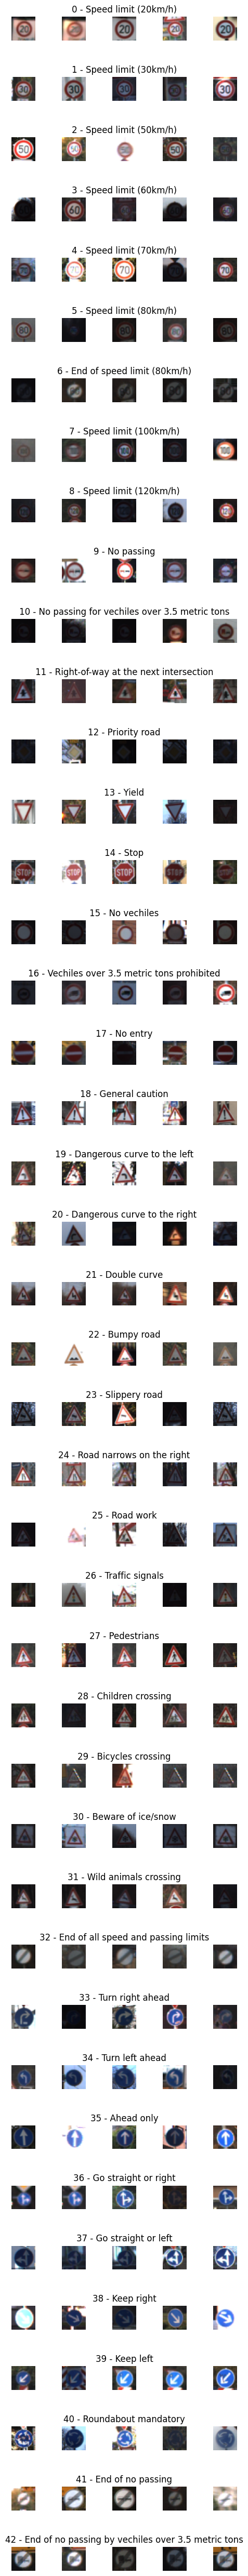

In [7]:
num_of_samples=[]
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout() 

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

Так же посмотрим на распределение данных

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


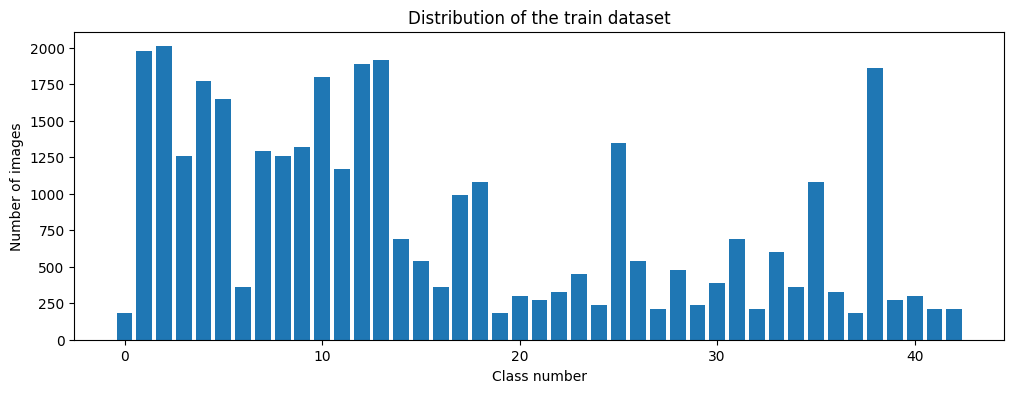

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

Как видно, у нас не одинаковое количество знаков в каждой из 43ёх подгруппах

Посмотрим как выглядит один из примеров датасета

(32, 32, 3)
36


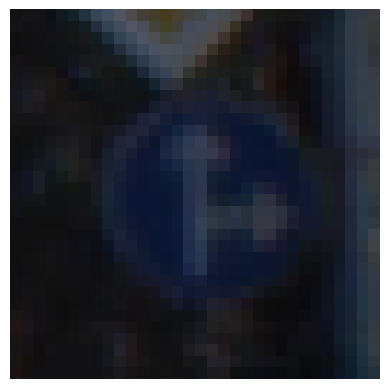

In [9]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

## Аугментация изображений

Теперь напишем функцию для преобразования картинки в черно-белую и посмотрим на результат

(32, 32)


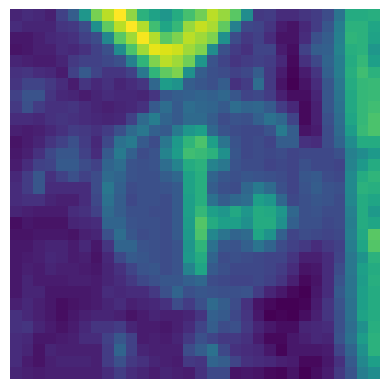

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

Далее используем функцию для расширения диапазона интенсивности изображения

(32, 32)


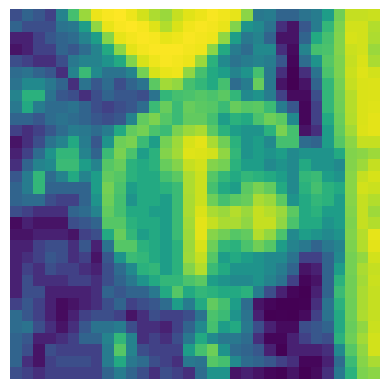

In [11]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

Теперь напишем функцию которая совместит эти две функции и вернёт полученное изображение

(32, 32)


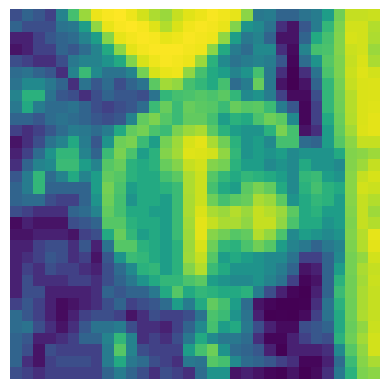

In [12]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
img = preprocess(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

Применим данную функцию ко всем данным

In [13]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

Посмотрим на случайное изображение из датасета получившееся по итогу

(34799, 32, 32)


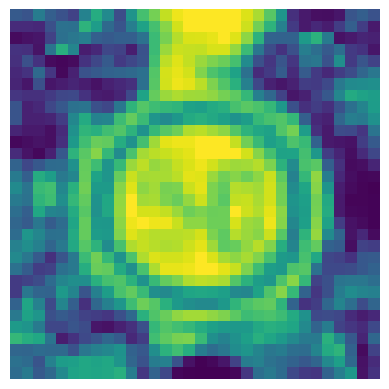

In [14]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [15]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

Далее, для того чтобы обучилась стабильно и не переобучилась на конкретном датасете необходимо аугментировать изображения. Используем функцию ImageDataGenerator, она применит к каждому изображению из датасета преобразования указанные в параметрах функции 

In [16]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)

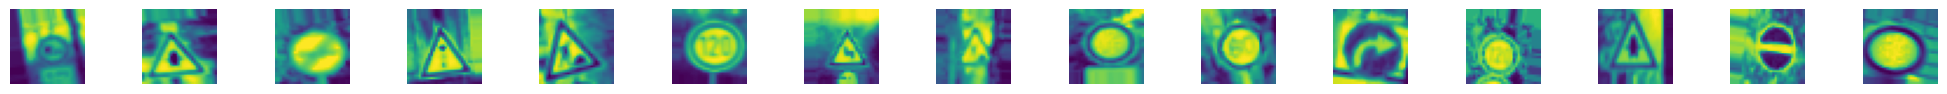

In [17]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")   

Сделаем из нашего датасета категориальные признаки

In [18]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

Создадим свёрточную нейронную сеть  архитектуры leNet для классификации дорожных знаков. Она состоит из двух свёрточных слоёв, после идёт pooling слой, далее снова 2 свёртки, потом снова pooling, а далее идут 2 полносвязных слоя, последний из которых относит поступившее на вход изображение к одному из 43-ёх классов.

## Создание и обучение CNN

In [19]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(Conv2D(30, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(43, activation='softmax'))
  
    model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                    

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Обучим нейронную сеть на 15 эпохах с размером батча 15

In [20]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=X_train.shape[0]/50,
                            epochs=15,
                            validation_data=(X_val, y_val), shuffle = 1)

C:\Users\User\AppData\Local\Temp\ipykernel_3080\2580822229.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


Epoch 1/15
695/695 [==============================] - 110s 158ms/step - loss: 1.7963 - accuracy: 0.4951 - val_loss: 0.2927 - val_accuracy: 0.9204
Epoch 2/15
695/695 [==============================] - 107s 154ms/step - loss: 0.5390 - accuracy: 0.8353 - val_loss: 0.1380 - val_accuracy: 0.9549
Epoch 3/15
695/695 [==============================] - 106s 153ms/step - loss: 0.3216 - accuracy: 0.8990 - val_loss: 0.0875 - val_accuracy: 0.9751
Epoch 4/15
695/695 [==============================] - 120s 172ms/step - loss: 0.2358 - accuracy: 0.9255 - val_loss: 0.0674 - val_accuracy: 0.9791
Epoch 5/15
695/695 [==============================] - 123s 176ms/step - loss: 0.1947 - accuracy: 0.9380 - val_loss: 0.0689 - val_accuracy: 0.9791
Epoch 6/15
695/695 [==============================] - 111s 159ms/step - loss: 0.1705 - accuracy: 0.9472 - val_loss: 0.0558 - val_accuracy: 0.9830
Epoch 7/15
695/695 [==============================] - 106s 152ms/step - loss: 0.1499 - accuracy: 0.9543 - val_loss: 0.0491 -

Построим график тренировочной и валидационной лосс функции

Text(0.5, 0, 'epoch')

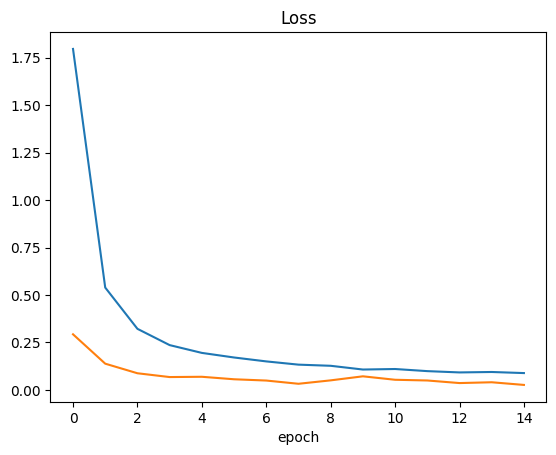

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Далее посмотрим на Accuracy

Test score: 0.09058907628059387
Test accuracy: 0.9726049304008484


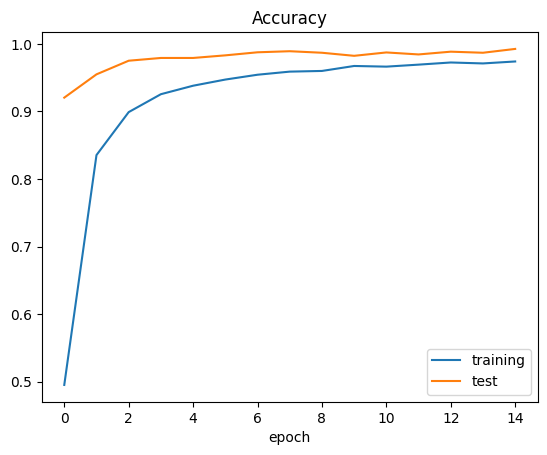

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch') 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Как видно, точность модели близка к 1

## Тестирование

Загрузим рандомный дорожный знак и проверим нашу модель на нём

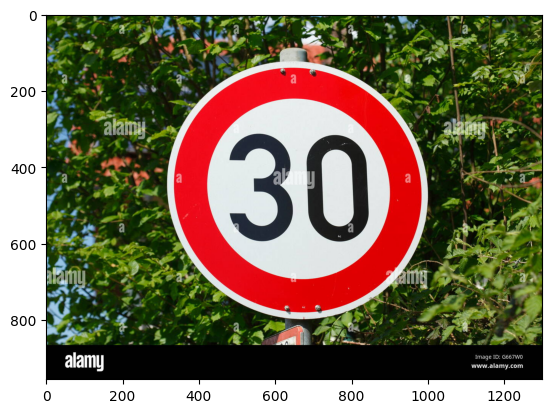

In [24]:
url = 'https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

Применим наши функции предобработки к тестовому изображению

(32, 32)


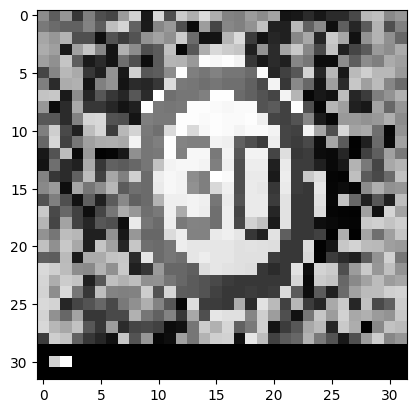

In [25]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

Предскажем класс

In [49]:
y_prob = model.predict(img) 
y_classes = y_prob.argmax(axis=-1)
print("Предсказанный класс: "+ str(y_classes)+ ' - ' + str(data[data['ClassId']== y_classes[0]]['SignName'][1]) )

1/1 [==============================] - 0s 18ms/step
Предсказанный класс: [1] - Speed limit (30km/h)


Сверяем с фактическим знаком, получаем что модель не ошиблась.